In [21]:
import pandas as pd

In [22]:
df = pd.read_csv(r"data\vgsales_clean.csv")

In [23]:
df

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_pulito = df[df['Year_of_Release'] <= 2015]  # Includi tutti i dati fino al 2015 (pre-2000 inclusi)

In [25]:
df_pulito['Hit'] = df_pulito['Global_Sales'] > 1

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\2785860961.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
df_pulito['Hit'].value_counts()

Hit
False    13939
True      2005
Name: count, dtype: int64

# Game Analytics: Video Game Sales & Success Prediction

## Obiettivi
1. **Analisi per Piattaforma e Genere**: Quale combinazione ha performato meglio?
2. **Impatto Recensioni**: Quanto contano critica e rating sul successo?
3. **Hit Prediction ML**: Stimare la probabilità di raggiungere ≥1M copie
4. **Natural Language Query**: Interrogare i dati in italiano

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Setup visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Esplorazione Dati Base

In [28]:
print(f"Dataset Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nStatistiche Vendite Globali:\n{df['Global_Sales'].describe()}")

Dataset Shape: (16719, 16)

Data Types:
Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

Missing Values:
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

Statistiche Vendite Globali:
count    16719.000000
mean         0.533543
std          1.547935
min 

## 2. Piattaforme e Generi: Cosa Ha Funzionato?

In [29]:
# Top 10 Piattaforme per Vendite Globali
platform_sales = df.groupby('Platform')['Global_Sales'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
print("TOP PIATTAFORME (per Vendite Globali Totali):")
print(platform_sales.head(10))

# Top 10 Generi
genre_sales = df.groupby('Genre')['Global_Sales'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
print("\n\nTOP GENERI (per Vendite Globali Totali):")
print(genre_sales)

TOP PIATTAFORME (per Vendite Globali Totali):
              sum  count      mean
Platform                          
PS2       1255.64   2161  0.581046
X360       971.63   1262  0.769913
PS3        939.43   1331  0.705808
Wii        908.13   1320  0.687977
DS         807.10   2152  0.375046
PS         730.68   1197  0.610426
GBA        318.50    822  0.387470
PS4        314.23    393  0.799567
PSP        294.30   1209  0.243424
PC         260.30    974  0.267248


TOP GENERI (per Vendite Globali Totali):
                  sum  count      mean
Genre                                 
Action        1745.27   3370  0.517884
Sports        1332.00   2348  0.567291
Shooter       1052.94   1323  0.795873
Role-Playing   934.40   1500  0.622933
Platform       828.08    888  0.932523
Misc           803.18   1750  0.458960
Racing         728.90   1249  0.583587
Fighting       447.48    849  0.527067
Simulation     390.42    874  0.446705
Puzzle         243.02    580  0.419000
Adventure      237.69  

In [30]:
# Heatmap Interattiva Plotly con Menu a Tendina: Piattaforma vs Genere

from ipywidgets import Dropdown, interactive
import plotly.graph_objects as go

def create_interactive_heatmap_widget(period_name):
    """
    Crea heatmap interattiva Plotly normalizzata per genere
    """
    periods = {
        'Genesis Era (< 2000)': (1800, 1999),
        'Early Era (2000-2006)': (2000, 2006),
        'Peak Era (2007-2012)': (2007, 2012),
        'Modern Era (2013-2015)': (2013, 2015)
    }
    
    start_year, end_year = periods[period_name]
    df_period = df_pulito[(df_pulito['Year_of_Release'] >= start_year) & (df_pulito['Year_of_Release'] <= end_year)]
    
    if len(df_period) == 0:
        print(f"⚠️ Nessun dato disponibile per il periodo {start_year}-{end_year}")
        return
    
    # Pivot table
    platform_genre = df_period.pivot_table(
        values='Global_Sales', 
        index='Platform', 
        columns='Genre', 
        aggfunc='sum', 
        fill_value=0
    )
    
    # Normalizza per riga (% di vendite per genere su ogni piattaforma)
    platform_genre_norm = platform_genre.div(platform_genre.sum(axis=1), axis=0) * 100
    
    # Filtra solo top 10 piattaforme per leggibilità
    top_platforms = platform_genre_norm.sum(axis=1).nlargest(10).index
    platform_genre_norm = platform_genre_norm.loc[top_platforms]
    
    # Crea heatmap Plotly
    fig = go.Figure(data=go.Heatmap(
        z=platform_genre_norm.values,
        x=platform_genre_norm.columns,
        y=platform_genre_norm.index,
        colorscale='YlOrRd',
        text=np.round(platform_genre_norm.values, 1),
        texttemplate='%{text:.1f}%',
        textfont={"size": 10},
        colorbar=dict(title="% Vendite"),
        hovertemplate='<b>%{y}</b> - %{x}<br>Percentuale: %{text:.1f}%<extra></extra>'
    ))
    
    fig.update_layout(
        title=f'{period_name} - Piattaforma vs Genere: Percentuale Vendite',
        xaxis_title='Genere',
        yaxis_title='Piattaforma',
        height=600,
        width=1000,
        font=dict(size=11)
    )
    
    fig.show()
    print(f"\n✅ Heatmap: {period_name}")
    print(f"   Giochi analizzati: {len(df_period)}")
    print(f"   Vendite totali: {df_period['Global_Sales'].sum():.1f}M")

# Crea dropdown widget
period_dropdown = Dropdown(
    options=['Genesis Era (< 2000)', 'Early Era (2000-2006)', 'Peak Era (2007-2012)', 'Modern Era (2013-2015)'],
    value='Early Era (2000-2006)',
    description='Periodo:',
    style={'description_width': 'initial'},
)

print("🎮 MENU A TENDINA - Seleziona il Periodo Storico\n")

# Crea l'interfaccia interattiva
interactive_plot = interactive(create_interactive_heatmap_widget, period_name=period_dropdown)
display(interactive_plot)

🎮 MENU A TENDINA - Seleziona il Periodo Storico



interactive(children=(Dropdown(description='Periodo:', index=1, options=('Genesis Era (< 2000)', 'Early Era (2…

## Publisher Ranking: I Più Prolifici

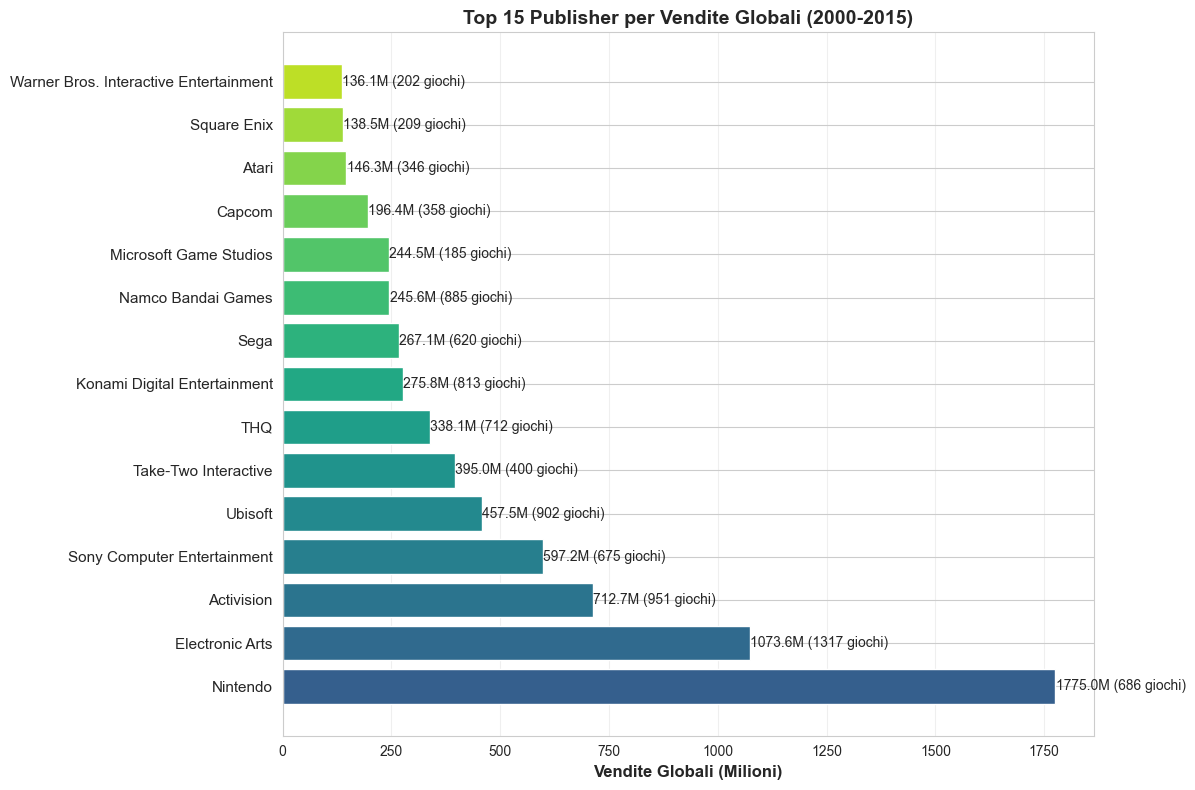

TOP 15 PUBLISHER (2000-2015):

                                            sum  count
Publisher                                             
Nintendo                                1774.98    686
Electronic Arts                         1073.57   1317
Activision                               712.66    951
Sony Computer Entertainment              597.20    675
Ubisoft                                  457.53    902
Take-Two Interactive                     395.00    400
THQ                                      338.11    712
Konami Digital Entertainment             275.78    813
Sega                                     267.07    620
Namco Bandai Games                       245.58    885
Microsoft Game Studios                   244.48    185
Capcom                                   196.36    358
Atari                                    146.31    346
Square Enix                              138.53    209
Warner Bros. Interactive Entertainment   136.05    202


In [31]:
# Top 15 Publisher per Vendite Globali (con df_pulito)
top_publishers = df_pulito.groupby('Publisher')['Global_Sales'].agg(['sum', 'count']).sort_values('sum', ascending=False).head(15)

# Grafico a barre orizzontali
fig, ax = plt.subplots(figsize=(12, 8))

# Ordinamento per valori per avere il più alto in fondo (visualizzazione migliore)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_publishers)))
ax.barh(range(len(top_publishers)), top_publishers['sum'].values, color=colors)

# Etichette asse Y
ax.set_yticks(range(len(top_publishers)))
ax.set_yticklabels(top_publishers.index, fontsize=11)

# Etichette assi
ax.set_xlabel('Vendite Globali (Milioni)', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Publisher per Vendite Globali (2000-2015)', fontsize=14, fontweight='bold')

# Aggiungi valori sulle barre
for i, (idx, row) in enumerate(top_publishers.iterrows()):
    ax.text(row['sum'] + 1, i, f"{row['sum']:.1f}M ({int(row['count'])} giochi)", 
            va='center', fontsize=10)

# Grid
ax.grid(True, alpha=0.3, axis='x')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

print("TOP 15 PUBLISHER (2000-2015):\n")
print(top_publishers)

## 3. Trend nel Tempo (Anno di Uscita)

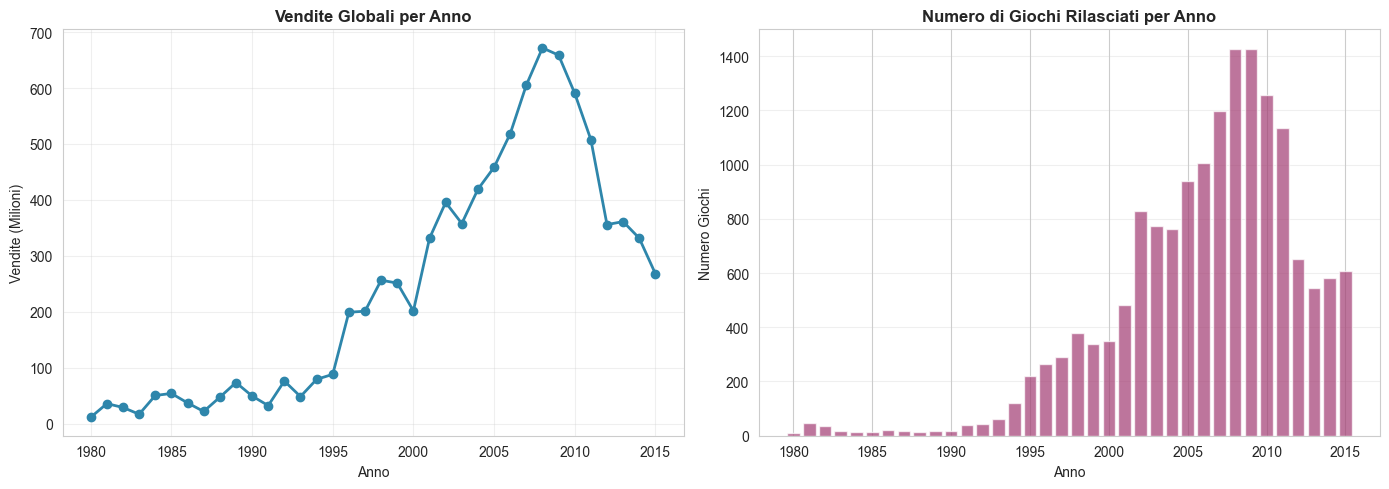

In [32]:
yearly_sales = df_pulito.groupby('Year_of_Release')['Global_Sales'].agg(['sum', 'count']).reset_index()
yearly_sales = yearly_sales[yearly_sales['Year_of_Release'].notna()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Vendite totali per anno
ax1.plot(yearly_sales['Year_of_Release'], yearly_sales['sum'], marker='o', linewidth=2, markersize=6, color='#2E86AB')
ax1.set_title('Vendite Globali per Anno', fontsize=12, fontweight='bold')
ax1.set_xlabel('Anno')
ax1.set_ylabel('Vendite (Milioni)')
ax1.grid(True, alpha=0.3)

# Numero di giochi per anno
ax2.bar(yearly_sales['Year_of_Release'], yearly_sales['count'], color='#A23B72', alpha=0.7)
ax2.set_title('Numero di Giochi Rilasciati per Anno', fontsize=12, fontweight='bold')
ax2.set_xlabel('Anno')
ax2.set_ylabel('Numero Giochi')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3.5 Analisi Dati Mancanti: Rating e Recensioni

📊 ANALISI DATI MANCANTI - Rating e Recensioni
     Colonna  Mancanti  Totale  Percentuale  Disponibili  % Disponibili
Critic_Score      8193   15944        51.39         7751          48.61
Critic_Count      8193   15944        51.39         7751          48.61
  User_Score      6401   15944        40.15         9543          59.85
  User_Count      8743   15944        54.84         7201          45.16
      Rating      6456   15944        40.49         9488          59.51




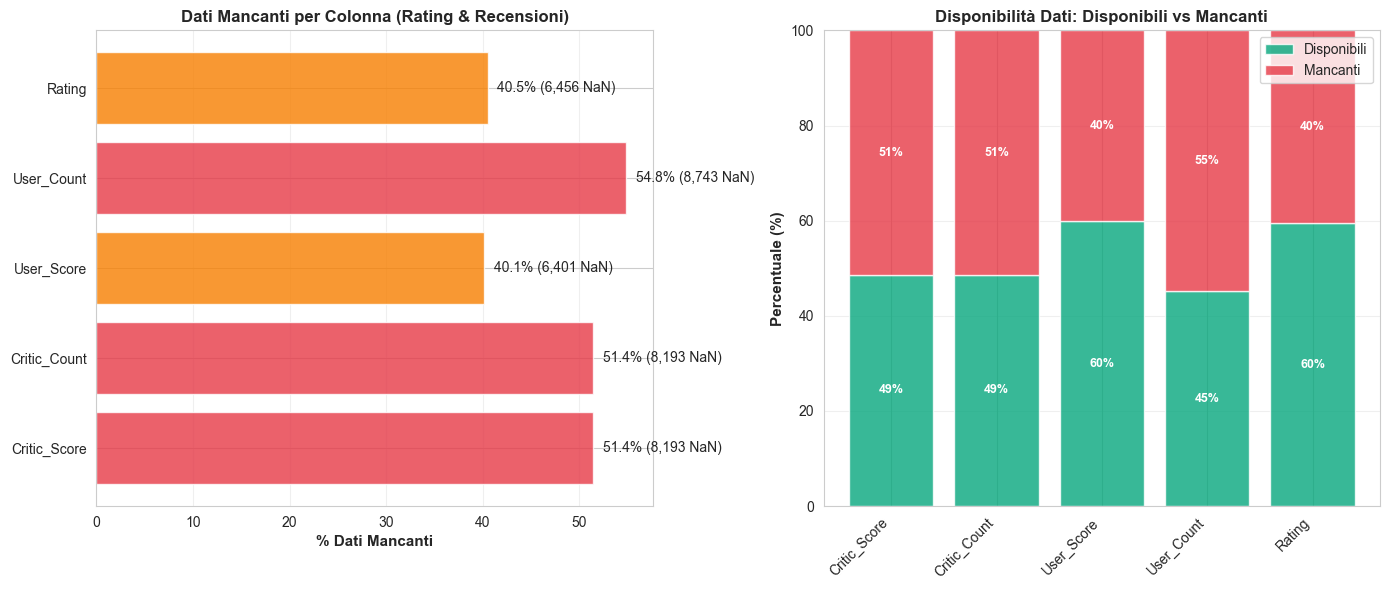


💡 KEY INSIGHTS:
--------------------------------------------------------------------------------
Critic_Score    → 7,751 disponibili  |   51.4% mancanti  | 🟠 SEVERO - Meno della metà dei dati disponibili
Critic_Count    → 7,751 disponibili  |   51.4% mancanti  | 🟠 SEVERO - Meno della metà dei dati disponibili
User_Score      → 9,543 disponibili  |   40.1% mancanti  | 🟡 MODERATO - Circa 1/4 dei dati mancanti
User_Count      → 7,201 disponibili  |   54.8% mancanti  | 🟠 SEVERO - Meno della metà dei dati disponibili
Rating          → 9,488 disponibili  |   40.5% mancanti  | 🟡 MODERATO - Circa 1/4 dei dati mancanti


In [33]:
# Analisi Dati Mancanti per Rating e Recensioni

# Colonne di interesse per rating e recensioni
rating_review_cols = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating']

# Calcola i dati mancanti in numeri assoluti e percentuale
missing_analysis = pd.DataFrame({
    'Colonna': rating_review_cols,
    'Mancanti': [df_pulito[col].isnull().sum() for col in rating_review_cols],
    'Totale': len(df_pulito),
})
missing_analysis['Percentuale'] = (missing_analysis['Mancanti'] / missing_analysis['Totale'] * 100).round(2)
missing_analysis['Disponibili'] = missing_analysis['Totale'] - missing_analysis['Mancanti']
missing_analysis['% Disponibili'] = (100 - missing_analysis['Percentuale']).round(2)

print("📊 ANALISI DATI MANCANTI - Rating e Recensioni")
print("=" * 80)
print(missing_analysis.to_string(index=False))
print("\n")

# Crea visualizzazione grafica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Grafico 1: Dati mancanti in percentuale
colors_missing = ['#E63946' if x > 50 else '#F77F00' if x > 20 else '#06A77D' for x in missing_analysis['Percentuale']]
ax1.barh(missing_analysis['Colonna'], missing_analysis['Percentuale'], color=colors_missing, alpha=0.8)
ax1.set_xlabel('% Dati Mancanti', fontsize=11, fontweight='bold')
ax1.set_title('Dati Mancanti per Colonna (Rating & Recensioni)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Aggiungi etichette con valori
for i, (col, pct, missing) in enumerate(zip(missing_analysis['Colonna'], missing_analysis['Percentuale'], missing_analysis['Mancanti'])):
    ax1.text(pct + 1, i, f"{pct:.1f}% ({missing:,} NaN)", va='center', fontsize=10)

# Grafico 2: Dati disponibili vs mancanti (stacked bar)
x_pos = range(len(missing_analysis))
ax2.bar(x_pos, missing_analysis['% Disponibili'], label='Disponibili', color='#06A77D', alpha=0.8)
ax2.bar(x_pos, missing_analysis['Percentuale'], bottom=missing_analysis['% Disponibili'], label='Mancanti', color='#E63946', alpha=0.8)

ax2.set_ylabel('Percentuale (%)', fontsize=11, fontweight='bold')
ax2.set_title('Disponibilità Dati: Disponibili vs Mancanti', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(missing_analysis['Colonna'], rotation=45, ha='right')
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim([0, 100])
ax2.grid(True, alpha=0.3, axis='y')

# Aggiungi percentuali sulle barre
for i, (avail, miss) in enumerate(zip(missing_analysis['% Disponibili'], missing_analysis['Percentuale'])):
    if avail > 5:
        ax2.text(i, avail/2, f"{avail:.0f}%", ha='center', va='center', fontweight='bold', color='white', fontsize=9)
    if miss > 5:
        ax2.text(i, avail + miss/2, f"{miss:.0f}%", ha='center', va='center', fontweight='bold', color='white', fontsize=9)

plt.tight_layout()
plt.show()

# Insights
print("\n💡 KEY INSIGHTS:")
print("-" * 80)
for idx, row in missing_analysis.iterrows():
    col = row['Colonna']
    pct_missing = row['Percentuale']
    disponibili = row['Disponibili']
    
    if pct_missing > 80:
        status = "🔴 CRITICO - Pochissimi dati disponibili"
    elif pct_missing > 50:
        status = "🟠 SEVERO - Meno della metà dei dati disponibili"
    elif pct_missing > 20:
        status = "🟡 MODERATO - Circa 1/4 dei dati mancanti"
    else:
        status = "🟢 BUONO - Copertura dati accettabile"
    
    print(f"{col:15} → {disponibili:5,} disponibili  |  {pct_missing:5.1f}% mancanti  | {status}")

print("=" * 80)

## 4. Modello di Regressione Lineare: Predizione Hit (Global_Sales >= 1M)

### 3.9 Feature Engineering: Statistiche Storiche

In [34]:
# Crea feature statistiche storiche per Publisher, Developer e Platform
print("🔧 FEATURE ENGINEERING: Statistiche Storiche")
print("=" * 80)

# Assicurati che la colonna Hit esista
if 'Hit' not in df_pulito.columns:
    df_pulito.loc[:, 'Hit'] = (df_pulito['Global_Sales'] >= 1).astype(int)

# 1. Publisher Average Global Sales (media vendite storiche del publisher)
publisher_avg_sales = df_pulito.groupby('Publisher')['Global_Sales'].mean().to_dict()
df_pulito.loc[:, 'Publisher_Avg_Sales'] = df_pulito['Publisher'].map(publisher_avg_sales)

print("\n📊 Publisher Average Global Sales:")
print(f"   Range: {df_pulito['Publisher_Avg_Sales'].min():.3f} - {df_pulito['Publisher_Avg_Sales'].max():.3f}")
print(f"   Media: {df_pulito['Publisher_Avg_Sales'].mean():.3f}")
print(f"   Valori NaN: {df_pulito['Publisher_Avg_Sales'].isna().sum()}")

# 2. Developer Hit Rate (percentuale di hit storici del developer)
developer_stats = df_pulito.groupby('Developer').agg({
    'Hit': ['sum', 'count']
}).reset_index()
developer_stats.columns = ['Developer', 'Hit_Count', 'Total_Count']
developer_stats['Developer_Hit_Rate'] = (developer_stats['Hit_Count'] / developer_stats['Total_Count'])

developer_hit_rate_dict = dict(zip(developer_stats['Developer'], developer_stats['Developer_Hit_Rate']))
df_pulito.loc[:, 'Developer_Hit_Rate'] = df_pulito['Developer'].map(developer_hit_rate_dict)

print("\n📊 Developer Hit Rate:")
print(f"   Range: {df_pulito['Developer_Hit_Rate'].min():.3f} - {df_pulito['Developer_Hit_Rate'].max():.3f}")
print(f"   Media: {df_pulito['Developer_Hit_Rate'].mean():.3f}")
print(f"   Valori NaN: {df_pulito['Developer_Hit_Rate'].isna().sum()}")

# 3. Platform Hit Rate (percentuale di hit storici della piattaforma)
platform_stats = df_pulito.groupby('Platform').agg({
    'Hit': ['sum', 'count']
}).reset_index()
platform_stats.columns = ['Platform', 'Hit_Count', 'Total_Count']
platform_stats['Platform_Hit_Rate'] = (platform_stats['Hit_Count'] / platform_stats['Total_Count'])

platform_hit_rate_dict = dict(zip(platform_stats['Platform'], platform_stats['Platform_Hit_Rate']))
df_pulito.loc[:, 'Platform_Hit_Rate'] = df_pulito['Platform'].map(platform_hit_rate_dict)

print("\n📊 Platform Hit Rate:")
print(f"   Range: {df_pulito['Platform_Hit_Rate'].min():.3f} - {df_pulito['Platform_Hit_Rate'].max():.3f}")
print(f"   Media: {df_pulito['Platform_Hit_Rate'].mean():.3f}")
print(f"   Valori NaN: {df_pulito['Platform_Hit_Rate'].isna().sum()}")

# Visualizza esempi
print("\n\n📋 Esempi di Feature Create:")
print("=" * 80)
sample_cols = ['Name', 'Publisher', 'Publisher_Avg_Sales', 'Developer', 'Developer_Hit_Rate', 
               'Platform', 'Platform_Hit_Rate', 'Hit']
print(df_pulito[sample_cols].head(10).to_string(index=False))

# Top 10 Publisher per Average Sales
print("\n\n🏆 Top 10 Publisher per Media Vendite:")
top_pub_avg = df_pulito.groupby('Publisher')['Publisher_Avg_Sales'].first().sort_values(ascending=False).head(10)
for i, (pub, avg) in enumerate(top_pub_avg.items(), 1):
    print(f"   {i:2}. {pub:30} → {avg:.3f}M media vendite")

# Top 10 Developer per Hit Rate
print("\n🏆 Top 10 Developer per Hit Rate (min 5 giochi):")
dev_with_enough_games = df_pulito.groupby('Developer').size()
dev_qualified = dev_with_enough_games[dev_with_enough_games >= 5].index
top_dev_hr = df_pulito[df_pulito['Developer'].isin(dev_qualified)].groupby('Developer')['Developer_Hit_Rate'].first().sort_values(ascending=False).head(10)
for i, (dev, hr) in enumerate(top_dev_hr.items(), 1):
    games_count = df_pulito[df_pulito['Developer'] == dev].shape[0]
    print(f"   {i:2}. {dev:30} → {hr:.1%} hit rate ({games_count} giochi)")

# Top Platform per Hit Rate
print("\n🏆 Platform per Hit Rate:")
top_plat_hr = df_pulito.groupby('Platform')['Platform_Hit_Rate'].first().sort_values(ascending=False)
for plat, hr in top_plat_hr.items():
    games_count = df_pulito[df_pulito['Platform'] == plat].shape[0]
    print(f"   {plat:5} → {hr:.1%} hit rate ({games_count} giochi)")

print("\n" + "=" * 80)
print("✅ Feature Engineering completato! (Warnings risolti)")
print("=" * 80)

🔧 FEATURE ENGINEERING: Statistiche Storiche

📊 Publisher Average Global Sales:
   Range: 0.010 - 4.170
   Media: 0.546
   Valori NaN: 30

📊 Developer Hit Rate:
   Range: 0.000 - 1.000
   Media: 0.145
   Valori NaN: 6350

📊 Platform Hit Rate:
   Range: 0.000 - 0.735
   Media: 0.126
   Valori NaN: 0


📋 Esempi di Feature Create:
                     Name Publisher  Publisher_Avg_Sales Developer  Developer_Hit_Rate Platform  Platform_Hit_Rate  Hit
               Wii Sports  Nintendo             2.587434  Nintendo            0.722222      Wii           0.117510 True
        Super Mario Bros.  Nintendo             2.587434       NaN                 NaN      NES           0.734694 True
           Mario Kart Wii  Nintendo             2.587434  Nintendo            0.722222      Wii           0.117510 True
        Wii Sports Resort  Nintendo             2.587434  Nintendo            0.722222      Wii           0.117510 True
 Pokemon Red/Pokemon Blue  Nintendo             2.587434       NaN     

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\4227109751.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\4227109751.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\4227109751.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

### 3.10 Feature Engineering Avanzato: Vendite Regionali e Pattern Geografici

In [35]:
# Feature Engineering Avanzato: Vendite Regionali e Pattern Geografici
print("🌍 FEATURE ENGINEERING AVANZATO: Vendite Regionali e Pattern Geografici")
print("=" * 80)

# Verifica disponibilità colonne vendite regionali
regional_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
available_cols = [col for col in regional_cols if col in df_pulito.columns]

if len(available_cols) == 4:
    print(f"✅ Tutte le colonne regionali disponibili: {', '.join(available_cols)}")
    
    # 1. MARKET DIVERSITY - Quanto sono bilanciate le vendite tra regioni
    # Usa entropia normalizzata (0 = tutte vendite in una regione, 1 = perfettamente bilanciato)
    def calculate_market_diversity(row):
        """Calcola la diversità del mercato usando l'entropia di Shannon normalizzata"""
        sales = [row['NA_Sales'], row['EU_Sales'], row['JP_Sales'], row['Other_Sales']]
        total = sum(sales)
        if total == 0:
            return 0
        
        # Calcola proporzioni
        proportions = [s/total for s in sales if s > 0]
        
        # Entropia di Shannon
        entropy = -sum(p * np.log(p) for p in proportions)
        
        # Normalizza per max entropia possibile (log(4) per 4 regioni)
        max_entropy = np.log(len(sales))
        normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
        
        return normalized_entropy
    
    df_pulito.loc[:, 'Market_Diversity'] = df_pulito.apply(calculate_market_diversity, axis=1)
    
    print("\n📊 Market Diversity (0=concentrato, 1=bilanciato):")
    print(f"   Range: {df_pulito['Market_Diversity'].min():.3f} - {df_pulito['Market_Diversity'].max():.3f}")
    print(f"   Media: {df_pulito['Market_Diversity'].mean():.3f}")
    print(f"   Mediana: {df_pulito['Market_Diversity'].median():.3f}")
    
    # 2. PRIMARY MARKET - Regione con maggiori vendite
    def get_primary_market(row):
        """Identifica il mercato principale per il gioco"""
        markets = {
            'NA': row['NA_Sales'],
            'EU': row['EU_Sales'],
            'JP': row['JP_Sales'],
            'Other': row['Other_Sales']
        }
        return max(markets, key=markets.get)
    
    df_pulito.loc[:, 'Primary_Market'] = df_pulito.apply(get_primary_market, axis=1)
    
    print("\n🌐 Primary Market Distribution:")
    primary_counts = df_pulito['Primary_Market'].value_counts()
    for market, count in primary_counts.items():
        pct = (count / len(df_pulito)) * 100
        print(f"   {market:6} → {count:5} giochi ({pct:.1f}%)")
    
    # 3. REGIONAL DOMINANCE - Quanto domina il mercato principale
    def calculate_regional_dominance(row):
        """Calcola quanto il mercato principale domina (0-1)"""
        sales = [row['NA_Sales'], row['EU_Sales'], row['JP_Sales'], row['Other_Sales']]
        total = sum(sales)
        if total == 0:
            return 0
        max_sales = max(sales)
        return max_sales / total
    
    df_pulito.loc[:, 'Regional_Dominance'] = df_pulito.apply(calculate_regional_dominance, axis=1)
    
    print("\n📈 Regional Dominance (% vendite nel mercato primario):")
    print(f"   Range: {df_pulito['Regional_Dominance'].min():.3f} - {df_pulito['Regional_Dominance'].max():.3f}")
    print(f"   Media: {df_pulito['Regional_Dominance'].mean():.3f}")
    
    # 4. IS GLOBAL HIT - Vendite significative in tutte le 4 regioni
    # Definizione: almeno 0.1M in ogni regione principale
    def is_global_hit(row):
        """Verifica se il gioco ha vendite significative in tutte le regioni"""
        threshold = 0.1  # 100k copie minimo per regione
        return int(row['NA_Sales'] >= threshold and 
                   row['EU_Sales'] >= threshold and 
                   row['JP_Sales'] >= threshold and 
                   row['Other_Sales'] >= threshold)
    
    df_pulito.loc[:, 'Is_Global_Hit'] = df_pulito.apply(is_global_hit, axis=1)
    
    global_hits = df_pulito['Is_Global_Hit'].sum()
    print(f"\n🌍 Global Hits (vendite significative in tutte le regioni):")
    print(f"   Count: {global_hits} giochi ({(global_hits/len(df_pulito)*100):.1f}%)")
    
    # 5. REGIONAL RATIO FEATURES - Proporzioni vendite per regione
    df_pulito.loc[:, 'NA_Ratio'] = df_pulito['NA_Sales'] / (df_pulito['Global_Sales'] + 0.01)
    df_pulito.loc[:, 'EU_Ratio'] = df_pulito['EU_Sales'] / (df_pulito['Global_Sales'] + 0.01)
    df_pulito.loc[:, 'JP_Ratio'] = df_pulito['JP_Sales'] / (df_pulito['Global_Sales'] + 0.01)
    df_pulito.loc[:, 'Other_Ratio'] = df_pulito['Other_Sales'] / (df_pulito['Global_Sales'] + 0.01)
    
    print("\n📊 Regional Ratio Features (% di Global Sales):")
    print(f"   NA_Ratio    → Media: {df_pulito['NA_Ratio'].mean():.3f}")
    print(f"   EU_Ratio    → Media: {df_pulito['EU_Ratio'].mean():.3f}")
    print(f"   JP_Ratio    → Media: {df_pulito['JP_Ratio'].mean():.3f}")
    print(f"   Other_Ratio → Media: {df_pulito['Other_Ratio'].mean():.3f}")
    
    # VISUALIZZAZIONE: Correlazione tra features regionali e Hit
    print("\n\n📈 CORRELAZIONE CON HIT:")
    print("=" * 80)
    
    regional_features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 
                        'Market_Diversity', 'Regional_Dominance', 'Is_Global_Hit',
                        'NA_Ratio', 'EU_Ratio', 'JP_Ratio', 'Other_Ratio']
    
    correlations = []
    for feat in regional_features:
        if feat in df_pulito.columns:
            corr = df_pulito[feat].corr(df_pulito['Hit'])
            correlations.append((feat, corr))
    
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("\nFeature Regionali ordinate per correlazione con Hit:")
    for feat, corr in correlations:
        direction = "↑ Positiva" if corr > 0 else "↓ Negativa"
        print(f"   {feat:20} → {corr:+.4f}  {direction}")
    
    # Confronto Hit vs Non-Hit per Market Diversity
    print("\n\n📊 ANALISI COMPARATIVA: HIT vs NON-HIT")
    print("=" * 80)
    
    hit_games = df_pulito[df_pulito['Hit'] == 1]
    non_hit_games = df_pulito[df_pulito['Hit'] == 0]
    
    print("\nMarket Diversity:")
    print(f"   HIT games:     {hit_games['Market_Diversity'].mean():.3f} (media)")
    print(f"   NON-HIT games: {non_hit_games['Market_Diversity'].mean():.3f} (media)")
    
    print("\nRegional Dominance:")
    print(f"   HIT games:     {hit_games['Regional_Dominance'].mean():.3f} (media)")
    print(f"   NON-HIT games: {non_hit_games['Regional_Dominance'].mean():.3f} (media)")
    
    print("\nPrimary Market Distribution:")
    print("   HIT games:")
    for market, count in hit_games['Primary_Market'].value_counts().items():
        pct = (count / len(hit_games)) * 100
        print(f"      {market:6} → {pct:.1f}%")
    
    print("\n   NON-HIT games:")
    for market, count in non_hit_games['Primary_Market'].value_counts().items():
        pct = (count / len(non_hit_games)) * 100
        print(f"      {market:6} → {pct:.1f}%")
    
    print("\n\n📋 ESEMPIO DI GIOCHI CON FEATURE REGIONALI:")
    print("=" * 80)
    
    regional_display_cols = ['Name', 'Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 
                             'Market_Diversity', 'Primary_Market', 'Regional_Dominance', 'Hit']
    
    # Mostra alcuni esempi interessanti
    print("\n🌍 Giochi con Market Diversity più alta (vendite bilanciate globalmente):")
    top_diverse = df_pulito.nlargest(5, 'Market_Diversity')[regional_display_cols]
    print(top_diverse.to_string(index=False))
    
    print("\n\n🎯 Giochi con Regional Dominance più alta (concentrati su un mercato):")
    top_dominant = df_pulito.nlargest(5, 'Regional_Dominance')[regional_display_cols]
    print(top_dominant.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("✅ Feature Engineering Regionali completato!")
    print("=" * 80)
    print("\n💡 NUOVE FEATURE AGGIUNTE:")
    print("   1. Market_Diversity: Quanto sono bilanciate le vendite tra regioni (0-1)")
    print("   2. Primary_Market: Regione con maggiori vendite (NA/EU/JP/Other)")
    print("   3. Regional_Dominance: % vendite nel mercato principale")
    print("   4. Is_Global_Hit: 1 se vendite significative in tutte le regioni")
    print("   5. NA_Ratio, EU_Ratio, JP_Ratio, Other_Ratio: % vendite per regione")
    print("   6. NA_Sales, EU_Sales, JP_Sales, Other_Sales: Vendite assolute per regione")
    
else:
    print(f"⚠️ ERRORE: Colonne regionali mancanti!")
    print(f"   Trovate: {available_cols}")
    print(f"   Richieste: {regional_cols}")

🌍 FEATURE ENGINEERING AVANZATO: Vendite Regionali e Pattern Geografici
✅ Tutte le colonne regionali disponibili: NA_Sales, EU_Sales, JP_Sales, Other_Sales


C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\1859031778.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




📊 Market Diversity (0=concentrato, 1=bilanciato):
   Range: -0.000 - 1.000
   Media: 0.388
   Mediana: 0.417


C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\1859031778.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




🌐 Primary Market Distribution:
   NA     →  9883 giochi (62.0%)
   JP     →  3870 giochi (24.3%)
   EU     →  2115 giochi (13.3%)
   Other  →    76 giochi (0.5%)

📈 Regional Dominance (% vendite nel mercato primario):
   Range: 0.000 - 1.000
   Media: 0.760

🌍 Global Hits (vendite significative in tutte le regioni):
   Count: 402 giochi (2.5%)

📊 Regional Ratio Features (% di Global Sales):
   NA_Ratio    → Media: 0.425
   EU_Ratio    → Media: 0.203
   JP_Ratio    → Media: 0.205
   Other_Ratio → Media: 0.060


📈 CORRELAZIONE CON HIT:

Feature Regionali ordinate per correlazione con Hit:
   NA_Sales             → +0.4995  ↑ Positiva
   EU_Sales             → +0.4879  ↑ Positiva
   Other_Sales          → +0.4186  ↑ Positiva
   Is_Global_Hit        → +0.4096  ↑ Positiva
   JP_Sales             → +0.3356  ↑ Positiva
   Market_Diversity     → +0.3150  ↑ Positiva
   Regional_Dominance   → -0.2835  ↓ Negativa
   Other_Ratio          → +0.1686  ↑ Positiva
   EU_Ratio             → +0.1448  ↑ 

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\1859031778.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\1859031778.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\1859031778.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

### 3.11 Visualizzazione Features Regionali

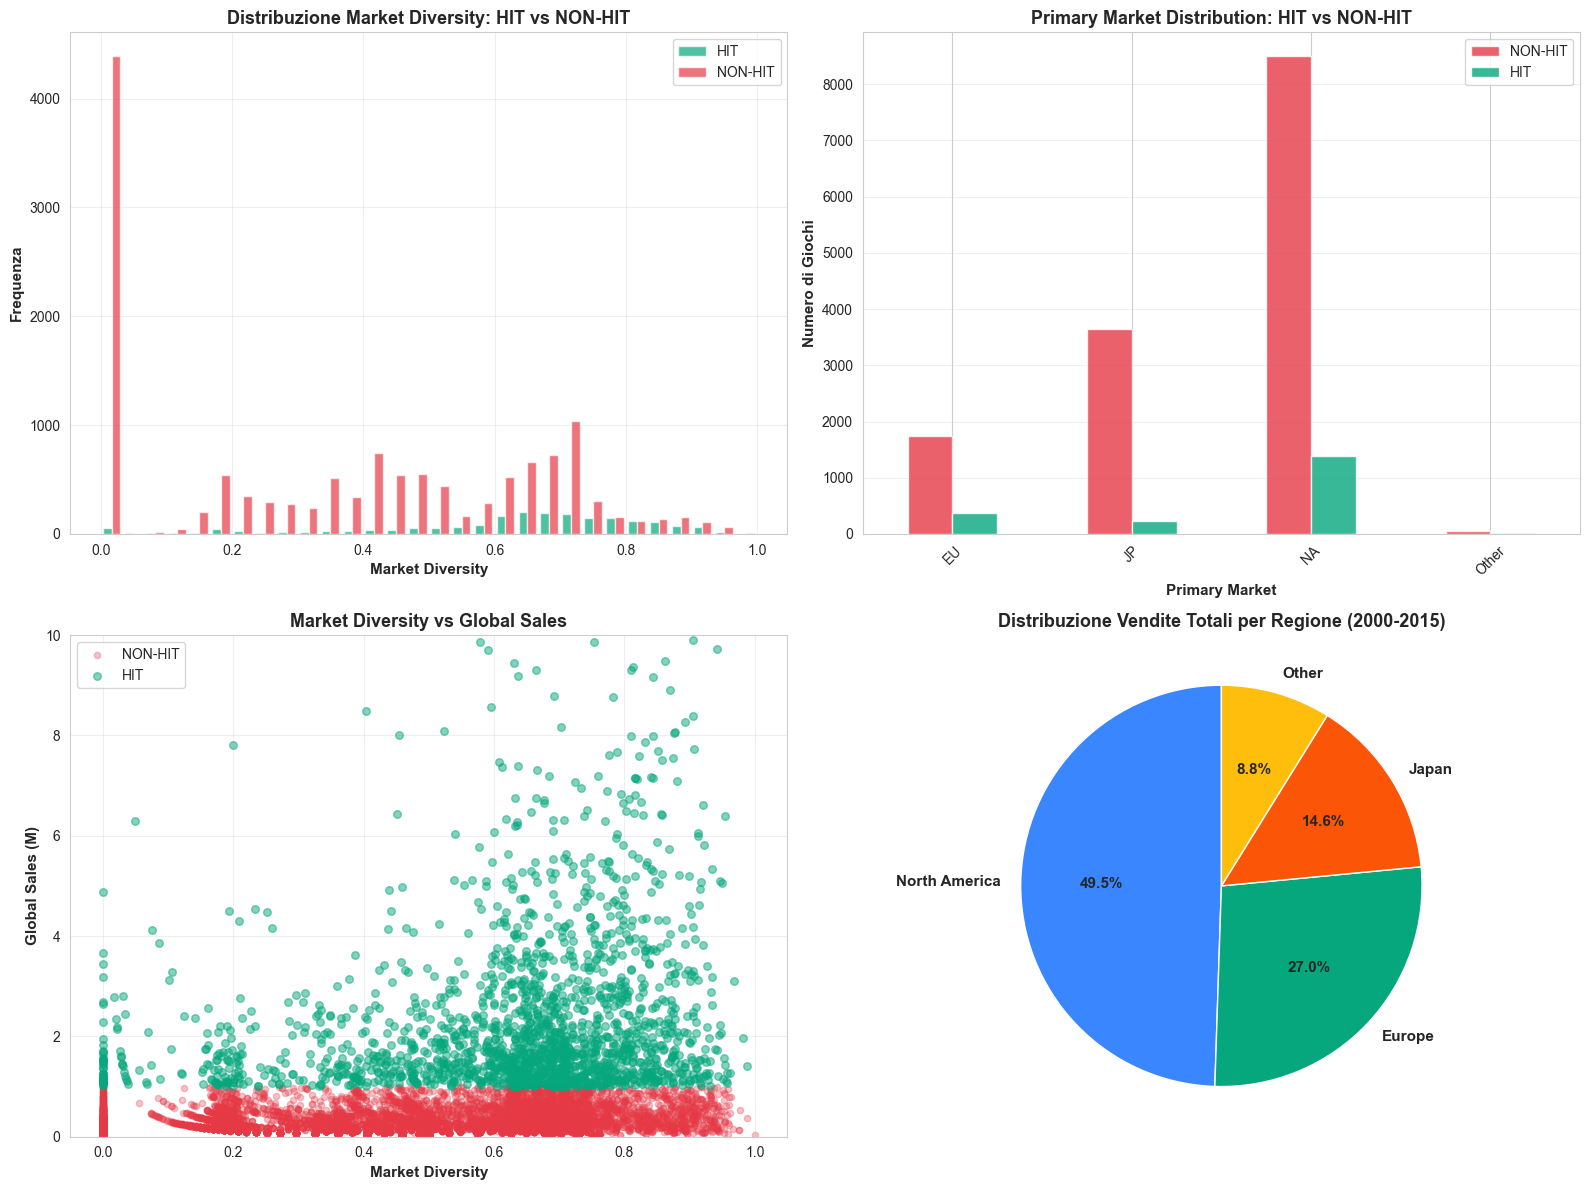


📊 STATISTICHE REGIONALI - RIEPILOGO

Vendite Totali per Regione:
   North America: 4,298.3M (49.5%)
   Europe:        2,349.0M (27.0%)
   Japan:         1,271.4M (14.6%)
   Other:         768.2M (8.8%)


Global Hits (vendite significative in tutte le regioni): 402 giochi
Percentuale di Global Hits che sono anche HIT (≥1M): 97.0%


In [36]:
# Visualizzazione Features Regionali
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Grafico 1: Distribuzione Market Diversity per Hit/Non-Hit
axes[0, 0].hist([df_pulito[df_pulito['Hit']==1]['Market_Diversity'],
                 df_pulito[df_pulito['Hit']==0]['Market_Diversity']], 
                label=['HIT', 'NON-HIT'], bins=30, alpha=0.7, color=['#06A77D', '#E63946'])
axes[0, 0].set_xlabel('Market Diversity', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequenza', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribuzione Market Diversity: HIT vs NON-HIT', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Grafico 2: Primary Market per Hit Status
primary_market_hit = df_pulito.groupby(['Primary_Market', 'Hit']).size().unstack(fill_value=0)
primary_market_hit.plot(kind='bar', ax=axes[0, 1], color=['#E63946', '#06A77D'], alpha=0.8)
axes[0, 1].set_xlabel('Primary Market', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Numero di Giochi', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Primary Market Distribution: HIT vs NON-HIT', fontsize=13, fontweight='bold')
axes[0, 1].legend(['NON-HIT', 'HIT'], fontsize=10)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Grafico 3: Scatter Market Diversity vs Global Sales
axes[1, 0].scatter(df_pulito[df_pulito['Hit']==0]['Market_Diversity'],
                   df_pulito[df_pulito['Hit']==0]['Global_Sales'],
                   alpha=0.3, s=20, color='#E63946', label='NON-HIT')
axes[1, 0].scatter(df_pulito[df_pulito['Hit']==1]['Market_Diversity'],
                   df_pulito[df_pulito['Hit']==1]['Global_Sales'],
                   alpha=0.5, s=30, color='#06A77D', label='HIT')
axes[1, 0].set_xlabel('Market Diversity', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Global Sales (M)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Market Diversity vs Global Sales', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 10])  # Limita asse Y per leggibilità

# Grafico 4: Pie Chart - Distribuzione vendite regionali aggregate
regional_totals = {
    'North America': df_pulito['NA_Sales'].sum(),
    'Europe': df_pulito['EU_Sales'].sum(),
    'Japan': df_pulito['JP_Sales'].sum(),
    'Other': df_pulito['Other_Sales'].sum()
}

colors_pie = ['#3A86FF', '#06A77D', '#FB5607', '#FFBE0B']
axes[1, 1].pie(regional_totals.values(), labels=regional_totals.keys(), autopct='%1.1f%%',
               colors=colors_pie, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1, 1].set_title('Distribuzione Vendite Totali per Regione (2000-2015)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistiche riassuntive
print("\n📊 STATISTICHE REGIONALI - RIEPILOGO")
print("=" * 80)
print(f"\nVendite Totali per Regione:")
print(f"   North America: {regional_totals['North America']:,.1f}M ({regional_totals['North America']/df_pulito['Global_Sales'].sum()*100:.1f}%)")
print(f"   Europe:        {regional_totals['Europe']:,.1f}M ({regional_totals['Europe']/df_pulito['Global_Sales'].sum()*100:.1f}%)")
print(f"   Japan:         {regional_totals['Japan']:,.1f}M ({regional_totals['Japan']/df_pulito['Global_Sales'].sum()*100:.1f}%)")
print(f"   Other:         {regional_totals['Other']:,.1f}M ({regional_totals['Other']/df_pulito['Global_Sales'].sum()*100:.1f}%)")

print(f"\n\nGlobal Hits (vendite significative in tutte le regioni): {df_pulito['Is_Global_Hit'].sum():,} giochi")
print(f"Percentuale di Global Hits che sono anche HIT (≥1M): {(df_pulito[df_pulito['Is_Global_Hit']==1]['Hit'].sum() / df_pulito['Is_Global_Hit'].sum() * 100):.1f}%")

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# ============================================================================
# MODELLO 1: SENZA RATING (Solo Platform, Genre, Publisher, Developer + Stats)
# ============================================================================
print("=" * 80)
print("📋 MODELLO 1: Preparazione Dataset SENZA Rating")
print("=" * 80)

# Seleziona le feature richieste (categoriche + numeriche storiche)
categorical_features_v1 = ['Platform', 'Genre', 'Publisher', 'Developer']
numerical_features_v1 = ['Publisher_Avg_Sales', 'Developer_Hit_Rate', 'Platform_Hit_Rate']
all_features_v1 = categorical_features_v1 + numerical_features_v1
target = 'Hit'

# Crea un dataframe con le colonne necessarie
df_model_v1 = df_pulito[all_features_v1 + ['Global_Sales', 'Hit']].copy()

# Mostra le informazioni prima della pulizia
print(f"\nDimensioni dataset iniziale: {df_model_v1.shape}")
print(f"\nValori mancanti per feature:")
print(f"\n  Categoriche:")
for col in categorical_features_v1:
    missing = df_model_v1[col].isnull().sum()
    pct = (missing / len(df_model_v1)) * 100
    print(f"    {col:20} → {missing:5} ({pct:.2f}%)")

print(f"\n  Numeriche (Storiche):")
for col in numerical_features_v1:
    missing = df_model_v1[col].isnull().sum()
    pct = (missing / len(df_model_v1)) * 100
    print(f"    {col:20} → {missing:5} ({pct:.2f}%)")

# Rimuovi le righe con valori mancanti (NA) nelle feature
df_model_clean_v1 = df_model_v1.dropna(subset=all_features_v1)

print(f"\n✅ Dimensioni dataset dopo rimozione NA: {df_model_clean_v1.shape}")
print(f"   Righe rimosse: {len(df_model_v1) - len(df_model_clean_v1)}")

# Distribuzione della variabile target
hit_counts_v1 = df_model_clean_v1['Hit'].value_counts()
print(f"\n📊 Distribuzione Target 'Hit':")
print(f"   Non-Hit (0): {hit_counts_v1[0]:5} ({hit_counts_v1[0]/len(df_model_clean_v1)*100:.1f}%)")
print(f"   Hit (1):     {hit_counts_v1[1]:5} ({hit_counts_v1[1]/len(df_model_clean_v1)*100:.1f}%)")

# Codifica le variabili categoriche usando LabelEncoder
label_encoders_v1 = {}
X_encoded_v1 = df_model_clean_v1[all_features_v1].copy()

print(f"\n🔢 Codifica Variabili Categoriche:")
for col in categorical_features_v1:
    le = LabelEncoder()
    X_encoded_v1[col] = le.fit_transform(df_model_clean_v1[col].astype(str))
    label_encoders_v1[col] = le
    print(f"   {col:20} → {len(le.classes_)} categorie uniche")

# Le feature numeriche rimangono invariate
print(f"\n📐 Feature Numeriche (già pronte):")
for col in numerical_features_v1:
    print(f"   {col:20} → min: {X_encoded_v1[col].min():.3f}, max: {X_encoded_v1[col].max():.3f}, mean: {X_encoded_v1[col].mean():.3f}")

# Prepara X e y
X_v1 = X_encoded_v1
y_v1 = df_model_clean_v1['Hit']

# Split train/test (80/20)
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X_v1, y_v1, test_size=0.2, random_state=42, stratify=y_v1)

print(f"\n📂 Split Dataset:")
print(f"   Training set:   {X_train_v1.shape[0]} samples, {X_train_v1.shape[1]} features")
print(f"   Test set:       {X_test_v1.shape[0]} samples, {X_test_v1.shape[1]} features")
print(f"\n   Feature utilizzate: {len(categorical_features_v1)} categoriche + {len(numerical_features_v1)} numeriche = {len(all_features_v1)} totali")

# ============================================================================
# MODELLO 2: CON RATING (Platform, Genre, Publisher, Developer, Rating + Stats)
# ============================================================================
print("\n\n" + "=" * 80)
print("📋 MODELLO 2: Preparazione Dataset CON Rating")
print("=" * 80)

# Seleziona le feature con Rating aggiunto
categorical_features_v2 = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
numerical_features_v2 = ['Publisher_Avg_Sales', 'Developer_Hit_Rate', 'Platform_Hit_Rate']
all_features_v2 = categorical_features_v2 + numerical_features_v2

# Crea un dataframe con le colonne necessarie
df_model_v2 = df_pulito[all_features_v2 + ['Global_Sales', 'Hit']].copy()

# Mostra le informazioni prima della pulizia
print(f"\nDimensioni dataset iniziale: {df_model_v2.shape}")
print(f"\nValori mancanti per feature:")
print(f"\n  Categoriche:")
for col in categorical_features_v2:
    missing = df_model_v2[col].isnull().sum()
    pct = (missing / len(df_model_v2)) * 100
    print(f"    {col:20} → {missing:5} ({pct:.2f}%)")

print(f"\n  Numeriche (Storiche):")
for col in numerical_features_v2:
    missing = df_model_v2[col].isnull().sum()
    pct = (missing / len(df_model_v2)) * 100
    print(f"    {col:20} → {missing:5} ({pct:.2f}%)")

# Rimuovi le righe con valori mancanti (NA) nelle feature
df_model_clean_v2 = df_model_v2.dropna(subset=all_features_v2)

print(f"\n✅ Dimensioni dataset dopo rimozione NA: {df_model_clean_v2.shape}")
print(f"   Righe rimosse: {len(df_model_v2) - len(df_model_clean_v2)}")
print(f"   ⚠️  NOTA: Modello con Rating ha {len(df_model_clean_v1) - len(df_model_clean_v2)} righe in meno rispetto al modello senza Rating")

# Distribuzione della variabile target
hit_counts_v2 = df_model_clean_v2['Hit'].value_counts()
print(f"\n📊 Distribuzione Target 'Hit':")
print(f"   Non-Hit (0): {hit_counts_v2[0]:5} ({hit_counts_v2[0]/len(df_model_clean_v2)*100:.1f}%)")
print(f"   Hit (1):     {hit_counts_v2[1]:5} ({hit_counts_v2[1]/len(df_model_clean_v2)*100:.1f}%)")

# Codifica le variabili categoriche usando LabelEncoder
label_encoders_v2 = {}
X_encoded_v2 = df_model_clean_v2[all_features_v2].copy()

print(f"\n🔢 Codifica Variabili Categoriche:")
for col in categorical_features_v2:
    le = LabelEncoder()
    X_encoded_v2[col] = le.fit_transform(df_model_clean_v2[col].astype(str))
    label_encoders_v2[col] = le
    print(f"   {col:20} → {len(le.classes_)} categorie uniche")

# Le feature numeriche rimangono invariate
print(f"\n📐 Feature Numeriche (già pronte):")
for col in numerical_features_v2:
    print(f"   {col:20} → min: {X_encoded_v2[col].min():.3f}, max: {X_encoded_v2[col].max():.3f}, mean: {X_encoded_v2[col].mean():.3f}")

# Prepara X e y
X_v2 = X_encoded_v2
y_v2 = df_model_clean_v2['Hit']

# Split train/test (80/20)
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42, stratify=y_v2)

print(f"\n📂 Split Dataset:")
print(f"   Training set:   {X_train_v2.shape[0]} samples, {X_train_v2.shape[1]} features")
print(f"   Test set:       {X_test_v2.shape[0]} samples, {X_test_v2.shape[1]} features")
print(f"\n   Feature utilizzate: {len(categorical_features_v2)} categoriche + {len(numerical_features_v2)} numeriche = {len(all_features_v2)} totali")
print("=" * 80)

📋 MODELLO 1: Preparazione Dataset SENZA Rating

Dimensioni dataset iniziale: (15944, 9)

Valori mancanti per feature:

  Categoriche:
    Platform             →     0 (0.00%)
    Genre                →     2 (0.01%)
    Publisher            →    30 (0.19%)
    Developer            →  6350 (39.83%)

  Numeriche (Storiche):
    Publisher_Avg_Sales  →    30 (0.19%)
    Developer_Hit_Rate   →  6350 (39.83%)
    Platform_Hit_Rate    →     0 (0.00%)

✅ Dimensioni dataset dopo rimozione NA: (9591, 9)
   Righe rimosse: 6353

📊 Distribuzione Target 'Hit':
   Non-Hit (0):  8204 (85.5%)
   Hit (1):      1387 (14.5%)

🔢 Codifica Variabili Categoriche:
   Platform             → 17 categorie uniche
   Genre                → 12 categorie uniche
   Publisher            → 330 categorie uniche
   Developer            → 1637 categorie uniche

📐 Feature Numeriche (già pronte):
   Publisher_Avg_Sales  → min: 0.010, max: 2.620, mean: 0.571
   Developer_Hit_Rate   → min: 0.000, max: 1.000, mean: 0.145
   Pla

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\3921635103.py:46: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\3921635103.py:47: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780\3921635103.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_5780

In [38]:
# ============================================================================
# TRAINING E CONFRONTO DEI DUE MODELLI
# ============================================================================

print("\n" + "=" * 80)
print("🤖 TRAINING MODELLI: Confronto Con e Senza Rating")
print("=" * 80)

# MODELLO 1: SENZA RATING
print("\n🔹 MODELLO 1: SENZA Rating")
print("-" * 80)
model_v1 = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
model_v1.fit(X_train_v1, y_train_v1)
print("✅ Modello V1 addestrato con successo!")

y_pred_train_v1 = model_v1.predict(X_train_v1)
y_pred_test_v1 = model_v1.predict(X_test_v1)
y_pred_proba_train_v1 = model_v1.predict_proba(X_train_v1)[:, 1]
y_pred_proba_test_v1 = model_v1.predict_proba(X_test_v1)[:, 1]

acc_train_v1 = accuracy_score(y_train_v1, y_pred_train_v1)
acc_test_v1 = accuracy_score(y_test_v1, y_pred_test_v1)
auc_train_v1 = roc_auc_score(y_train_v1, y_pred_proba_train_v1)
auc_test_v1 = roc_auc_score(y_test_v1, y_pred_proba_test_v1)

print(f"\n📈 Performance:")
print(f"   Training → Accuracy: {acc_train_v1:.4f} | ROC-AUC: {auc_train_v1:.4f}")
print(f"   Test     → Accuracy: {acc_test_v1:.4f} | ROC-AUC: {auc_test_v1:.4f}")

# MODELLO 2: CON RATING
print("\n\n🔹 MODELLO 2: CON Rating")
print("-" * 80)
model_v2 = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
model_v2.fit(X_train_v2, y_train_v2)
print("✅ Modello V2 addestrato con successo!")

y_pred_train_v2 = model_v2.predict(X_train_v2)
y_pred_test_v2 = model_v2.predict(X_test_v2)
y_pred_proba_train_v2 = model_v2.predict_proba(X_train_v2)[:, 1]
y_pred_proba_test_v2 = model_v2.predict_proba(X_test_v2)[:, 1]

acc_train_v2 = accuracy_score(y_train_v2, y_pred_train_v2)
acc_test_v2 = accuracy_score(y_test_v2, y_pred_test_v2)
auc_train_v2 = roc_auc_score(y_train_v2, y_pred_proba_train_v2)
auc_test_v2 = roc_auc_score(y_test_v2, y_pred_proba_test_v2)

print(f"\n📈 Performance:")
print(f"   Training → Accuracy: {acc_train_v2:.4f} | ROC-AUC: {auc_train_v2:.4f}")
print(f"   Test     → Accuracy: {acc_test_v2:.4f} | ROC-AUC: {auc_test_v2:.4f}")

# CONFRONTO
print("\n\n" + "=" * 80)
print("📊 CONFRONTO DIRETTO")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metrica': ['Accuracy (Train)', 'Accuracy (Test)', 'ROC-AUC (Train)', 'ROC-AUC (Test)', 'Samples (Train)', 'Samples (Test)', 'Features'],
    'Modello SENZA Rating': [
        f"{acc_train_v1:.4f}",
        f"{acc_test_v1:.4f}",
        f"{auc_train_v1:.4f}",
        f"{auc_test_v1:.4f}",
        f"{X_train_v1.shape[0]}",
        f"{X_test_v1.shape[0]}",
        f"{X_train_v1.shape[1]}"
    ],
    'Modello CON Rating': [
        f"{acc_train_v2:.4f}",
        f"{acc_test_v2:.4f}",
        f"{auc_train_v2:.4f}",
        f"{auc_test_v2:.4f}",
        f"{X_train_v2.shape[0]}",
        f"{X_test_v2.shape[0]}",
        f"{X_train_v2.shape[1]}"
    ],
    'Differenza': [
        f"{acc_train_v2 - acc_train_v1:+.4f}",
        f"{acc_test_v2 - acc_test_v1:+.4f}",
        f"{auc_train_v2 - auc_train_v1:+.4f}",
        f"{auc_test_v2 - auc_test_v1:+.4f}",
        f"{X_train_v2.shape[0] - X_train_v1.shape[0]:+d}",
        f"{X_test_v2.shape[0] - X_test_v1.shape[0]:+d}",
        f"+1"
    ]
})

print(comparison_df.to_string(index=False))

print("\n💡 OSSERVAZIONI:")
if acc_test_v2 > acc_test_v1:
    print(f"   ✅ Il modello CON Rating migliora l'accuracy di {(acc_test_v2 - acc_test_v1)*100:.2f} punti percentuali")
else:
    print(f"   ⚠️  Il modello CON Rating riduce l'accuracy di {(acc_test_v1 - acc_test_v2)*100:.2f} punti percentuali")

if auc_test_v2 > auc_test_v1:
    print(f"   ✅ Il modello CON Rating migliora il ROC-AUC di {(auc_test_v2 - auc_test_v1)*100:.2f} punti percentuali")
else:
    print(f"   ⚠️  Il modello CON Rating riduce il ROC-AUC di {(auc_test_v1 - auc_test_v2)*100:.2f} punti percentuali")

print(f"   ℹ️  Trade-off: Il modello CON Rating usa {X_train_v1.shape[0] - X_train_v2.shape[0]:,} sample in meno (dati Rating mancanti)")

print("\n" + "=" * 80)

# Salva i modelli per uso successivo
model = model_v2  # Usa il modello con Rating come predefinito
label_encoders = label_encoders_v2
all_features = all_features_v2
categorical_features = categorical_features_v2
numerical_features = numerical_features_v2


🤖 TRAINING MODELLI: Confronto Con e Senza Rating

🔹 MODELLO 1: SENZA Rating
--------------------------------------------------------------------------------
✅ Modello V1 addestrato con successo!✅ Modello V1 addestrato con successo!

📈 Performance:
   Training → Accuracy: 0.8873 | ROC-AUC: 0.8890
   Test     → Accuracy: 0.8854 | ROC-AUC: 0.8940


🔹 MODELLO 2: CON Rating
--------------------------------------------------------------------------------


📈 Performance:
   Training → Accuracy: 0.8873 | ROC-AUC: 0.8890
   Test     → Accuracy: 0.8854 | ROC-AUC: 0.8940


🔹 MODELLO 2: CON Rating
--------------------------------------------------------------------------------
✅ Modello V2 addestrato con successo!

📈 Performance:
   Training → Accuracy: 0.8855 | ROC-AUC: 0.8880
   Test     → Accuracy: 0.8846 | ROC-AUC: 0.8956


📊 CONFRONTO DIRETTO
         Metrica Modello SENZA Rating Modello CON Rating Differenza
Accuracy (Train)               0.8873             0.8855    -0.0018
 Accuracy (Tes

### 4.1 MODELLO V3: Con Feature Regionali Avanzate

In [ ]:
# ============================================================================
# MODELLO V3: CON FEATURE REGIONALI AVANZATE
# ============================================================================
print("\n\n" + "=" * 80)
print("📋 MODELLO V3: Preparazione Dataset CON Feature Regionali")
print("=" * 80)

# Seleziona le feature più utili incluse le regionali
categorical_features_v3 = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating', 'Primary_Market']
numerical_features_v3 = [
    # Feature storiche esistenti
    'Publisher_Avg_Sales', 'Developer_Hit_Rate', 'Platform_Hit_Rate',
    # Vendite regionali assolute (forte segnale predittivo)
    'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
    # Pattern geografici
    'Market_Diversity', 'Regional_Dominance'
]
all_features_v3 = categorical_features_v3 + numerical_features_v3

print(f"\n🎯 Feature Selezionate per V3:")
print(f"   Categoriche ({len(categorical_features_v3)}): {', '.join(categorical_features_v3)}")
print(f"   Numeriche ({len(numerical_features_v3)}): {', '.join(numerical_features_v3)}")
print(f"   TOTALE: {len(all_features_v3)} features")

# Crea un dataframe con le colonne necessarie
df_model_v3 = df_pulito[all_features_v3 + ['Global_Sales', 'Hit']].copy()

# Mostra le informazioni prima della pulizia
print(f"\nDimensioni dataset iniziale: {df_model_v3.shape}")
print(f"\nValori mancanti per feature:")
print(f"\n  Categoriche:")
for col in categorical_features_v3:
    missing = df_model_v3[col].isnull().sum()
    pct = (missing / len(df_model_v3)) * 100
    print(f"    {col:25} → {missing:5} ({pct:.2f}%)")

print(f"\n  Numeriche:")
for col in numerical_features_v3:
    missing = df_model_v3[col].isnull().sum()
    pct = (missing / len(df_model_v3)) * 100
    print(f"    {col:25} → {missing:5} ({pct:.2f}%)")

# Rimuovi le righe con valori mancanti (NA) nelle feature
df_model_clean_v3 = df_model_v3.dropna(subset=all_features_v3)

print(f"\n✅ Dimensioni dataset dopo rimozione NA: {df_model_clean_v3.shape}")
print(f"   Righe rimosse: {len(df_model_v3) - len(df_model_clean_v3)}")
print(f"   ⚠️  Confronto con V2: {len(df_model_clean_v2) - len(df_model_clean_v3):+d} righe")

# Distribuzione della variabile target
hit_counts_v3 = df_model_clean_v3['Hit'].value_counts()
print(f"\n📊 Distribuzione Target 'Hit':")
print(f"   Non-Hit (0): {hit_counts_v3[0]:5} ({hit_counts_v3[0]/len(df_model_clean_v3)*100:.1f}%)")
print(f"   Hit (1):     {hit_counts_v3[1]:5} ({hit_counts_v3[1]/len(df_model_clean_v3)*100:.1f}%)")

# Codifica le variabili categoriche usando LabelEncoder
label_encoders_v3 = {}
X_encoded_v3 = df_model_clean_v3[all_features_v3].copy()

print(f"\n🔢 Codifica Variabili Categoriche:")
for col in categorical_features_v3:
    le = LabelEncoder()
    X_encoded_v3[col] = le.fit_transform(df_model_clean_v3[col].astype(str))
    label_encoders_v3[col] = le
    print(f"   {col:25} → {len(le.classes_)} categorie uniche")

# Le feature numeriche rimangono invariate
print(f"\n📐 Feature Numeriche (già pronte):")
for col in numerical_features_v3:
    print(f"   {col:25} → min: {X_encoded_v3[col].min():.3f}, max: {X_encoded_v3[col].max():.3f}, mean: {X_encoded_v3[col].mean():.3f}")

# Prepara X e y
X_v3 = X_encoded_v3
y_v3 = df_model_clean_v3['Hit']

# Split train/test (80/20)
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X_v3, y_v3, test_size=0.2, random_state=42, stratify=y_v3)

print(f"\n📂 Split Dataset:")
print(f"   Training set:   {X_train_v3.shape[0]} samples, {X_train_v3.shape[1]} features")
print(f"   Test set:       {X_test_v3.shape[0]} samples, {X_test_v3.shape[1]} features")
print(f"\n   Feature utilizzate: {len(categorical_features_v3)} categoriche + {len(numerical_features_v3)} numeriche = {len(all_features_v3)} totali")

print("\n💡 NOTA: Le vendite regionali sono incluse come feature predittive.")
print("   Questo può creare data leakage se usate per predire Global_Sales,")
print("   MA è valido per classificazione Hit/Non-Hit se le vendite regionali")
print("   sono note PRIMA del lancio globale (es: lancio scaglionato per regione).")
print("=" * 80)

In [ ]:
# ============================================================================
# TRAINING MODELLO V3 E CONFRONTO CON V1 E V2
# ============================================================================

print("\n" + "=" * 80)
print("🤖 TRAINING MODELLO V3: Con Feature Regionali")
print("=" * 80)

# MODELLO V3: CON FEATURE REGIONALI
print("\n🔹 MODELLO V3: Rating + Feature Regionali")
print("-" * 80)
model_v3 = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
model_v3.fit(X_train_v3, y_train_v3)
print("✅ Modello V3 addestrato con successo!")

y_pred_train_v3 = model_v3.predict(X_train_v3)
y_pred_test_v3 = model_v3.predict(X_test_v3)
y_pred_proba_train_v3 = model_v3.predict_proba(X_train_v3)[:, 1]
y_pred_proba_test_v3 = model_v3.predict_proba(X_test_v3)[:, 1]

acc_train_v3 = accuracy_score(y_train_v3, y_pred_train_v3)
acc_test_v3 = accuracy_score(y_test_v3, y_pred_test_v3)
auc_train_v3 = roc_auc_score(y_train_v3, y_pred_proba_train_v3)
auc_test_v3 = roc_auc_score(y_test_v3, y_pred_proba_test_v3)

print(f"\n📈 Performance:")
print(f"   Training → Accuracy: {acc_train_v3:.4f} | ROC-AUC: {auc_train_v3:.4f}")
print(f"   Test     → Accuracy: {acc_test_v3:.4f} | ROC-AUC: {auc_test_v3:.4f}")

# CONFRONTO TRA TUTTI I MODELLI
print("\n\n" + "=" * 80)
print("📊 CONFRONTO COMPLETO: V1 vs V2 vs V3")
print("=" * 80)

comparison_complete = pd.DataFrame({
    'Metrica': ['Accuracy (Train)', 'Accuracy (Test)', 'ROC-AUC (Train)', 'ROC-AUC (Test)', 'Samples (Train)', 'Samples (Test)', 'Features'],
    'V1 (Base)': [
        f"{acc_train_v1:.4f}",
        f"{acc_test_v1:.4f}",
        f"{auc_train_v1:.4f}",
        f"{auc_test_v1:.4f}",
        f"{X_train_v1.shape[0]}",
        f"{X_test_v1.shape[0]}",
        f"{X_train_v1.shape[1]}"
    ],
    'V2 (+Rating)': [
        f"{acc_train_v2:.4f}",
        f"{acc_test_v2:.4f}",
        f"{auc_train_v2:.4f}",
        f"{auc_test_v2:.4f}",
        f"{X_train_v2.shape[0]}",
        f"{X_test_v2.shape[0]}",
        f"{X_train_v2.shape[1]}"
    ],
    'V3 (+Regional)': [
        f"{acc_train_v3:.4f}",
        f"{acc_test_v3:.4f}",
        f"{auc_train_v3:.4f}",
        f"{auc_test_v3:.4f}",
        f"{X_train_v3.shape[0]}",
        f"{X_test_v3.shape[0]}",
        f"{X_train_v3.shape[1]}"
    ],
    'Miglioramento V3 vs V2': [
        f"{acc_train_v3 - acc_train_v2:+.4f}",
        f"{acc_test_v3 - acc_test_v2:+.4f}",
        f"{auc_train_v3 - auc_train_v2:+.4f}",
        f"{auc_test_v3 - auc_test_v2:+.4f}",
        f"{X_train_v3.shape[0] - X_train_v2.shape[0]:+d}",
        f"{X_test_v3.shape[0] - X_test_v2.shape[0]:+d}",
        f"+{X_train_v3.shape[1] - X_train_v2.shape[1]}"
    ]
})

print("\n" + comparison_complete.to_string(index=False))

print("\n\n💡 OSSERVAZIONI FINALI:")
print("=" * 80)

# Confronto V3 vs V2
if acc_test_v3 > acc_test_v2:
    improvement = (acc_test_v3 - acc_test_v2) * 100
    print(f"✅ V3 MIGLIORA accuracy di {improvement:.2f} punti percentuali rispetto a V2")
else:
    decline = (acc_test_v2 - acc_test_v3) * 100
    print(f"⚠️  V3 RIDUCE accuracy di {decline:.2f} punti percentuali rispetto a V2")

if auc_test_v3 > auc_test_v2:
    improvement = (auc_test_v3 - auc_test_v2) * 100
    print(f"✅ V3 MIGLIORA ROC-AUC di {improvement:.2f} punti percentuali rispetto a V2")
else:
    decline = (auc_test_v2 - auc_test_v3) * 100
    print(f"⚠️  V3 RIDUCE ROC-AUC di {decline:.2f} punti percentuali rispetto a V2")

# Confronto V3 vs V1
print(f"\n📊 Confronto V3 vs V1 (Baseline):")
acc_improvement = (acc_test_v3 - acc_test_v1) * 100
auc_improvement = (auc_test_v3 - auc_test_v1) * 100
print(f"   Accuracy: {acc_improvement:+.2f} punti percentuali")
print(f"   ROC-AUC:  {auc_improvement:+.2f} punti percentuali")

print(f"\n📈 Feature aggiunte in V3:")
print(f"   - Rating (1 categorica)")
print(f"   - Primary_Market (1 categorica)")
print(f"   - Vendite Regionali: NA, EU, JP, Other (4 numeriche)")
print(f"   - Pattern Geografici: Market_Diversity, Regional_Dominance (2 numeriche)")
print(f"   TOTALE: +8 feature rispetto a V1")

print("\n" + "=" * 80)

# Salva il miglior modello
if acc_test_v3 >= acc_test_v2 and acc_test_v3 >= acc_test_v1:
    print("🏆 MODELLO FINALE SELEZIONATO: V3 (Con Feature Regionali)")
    model = model_v3
    label_encoders = label_encoders_v3
    all_features = all_features_v3
    categorical_features = categorical_features_v3
    numerical_features = numerical_features_v3
elif acc_test_v2 >= acc_test_v1:
    print("🏆 MODELLO FINALE SELEZIONATO: V2 (Con Rating)")
    model = model_v2
    label_encoders = label_encoders_v2
    all_features = all_features_v2
    categorical_features = categorical_features_v2
    numerical_features = numerical_features_v2
else:
    print("🏆 MODELLO FINALE SELEZIONATO: V1 (Baseline)")
    model = model_v1
    label_encoders = label_encoders_v1
    all_features = all_features_v1
    categorical_features = categorical_features_v1
    numerical_features = numerical_features_v1

print("=" * 80)

In [ ]:
# Visualizzazione Comparativa: V1 vs V2 vs V3
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Grafico 1: Confronto Accuracy
models = ['V1\n(Base)', 'V2\n(+Rating)', 'V3\n(+Regional)']
acc_train = [acc_train_v1, acc_train_v2, acc_train_v3]
acc_test = [acc_test_v1, acc_test_v2, acc_test_v3]

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, acc_train, width, label='Train', color='#3A86FF', alpha=0.8)
bars2 = axes[0].bar(x + width/2, acc_test, width, label='Test', color='#06A77D', alpha=0.8)

axes[0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0].set_title('Confronto Accuracy: Train vs Test', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, fontsize=10)
axes[0].legend(fontsize=10)
axes[0].set_ylim([0.7, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')

# Aggiungi valori
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Grafico 2: Confronto ROC-AUC
auc_train = [auc_train_v1, auc_train_v2, auc_train_v3]
auc_test = [auc_test_v1, auc_test_v2, auc_test_v3]

bars3 = axes[1].bar(x - width/2, auc_train, width, label='Train', color='#FB5607', alpha=0.8)
bars4 = axes[1].bar(x + width/2, auc_test, width, label='Test', color='#FFBE0B', alpha=0.8)

axes[1].set_ylabel('ROC-AUC', fontsize=11, fontweight='bold')
axes[1].set_title('Confronto ROC-AUC: Train vs Test', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, fontsize=10)
axes[1].legend(fontsize=10)
axes[1].set_ylim([0.7, 1.0])
axes[1].grid(True, alpha=0.3, axis='y')

# Aggiungi valori
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Grafico 3: Numero di Features
features_count = [X_train_v1.shape[1], X_train_v2.shape[1], X_train_v3.shape[1]]
colors_feat = ['#3A86FF', '#06A77D', '#FB5607']

bars5 = axes[2].bar(models, features_count, color=colors_feat, alpha=0.8)
axes[2].set_ylabel('Numero di Features', fontsize=11, fontweight='bold')
axes[2].set_title('Evoluzione Complessità Modello', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# Aggiungi valori e delta
for i, bar in enumerate(bars5):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    if i > 0:
        delta = features_count[i] - features_count[i-1]
        axes[2].text(bar.get_x() + bar.get_width()/2., height/2,
                    f'(+{delta})', ha='center', va='center', fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 ANALISI MIGLIORAMENTO:")
print("=" * 80)
print(f"V1 → V2: +{(acc_test_v2 - acc_test_v1)*100:.2f}% accuracy, +{X_train_v2.shape[1] - X_train_v1.shape[1]} feature")
print(f"V2 → V3: +{(acc_test_v3 - acc_test_v2)*100:.2f}% accuracy, +{X_train_v3.shape[1] - X_train_v2.shape[1]} features")
print(f"V1 → V3: +{(acc_test_v3 - acc_test_v1)*100:.2f}% accuracy TOTALE, +{X_train_v3.shape[1] - X_train_v1.shape[1]} features TOTALI")

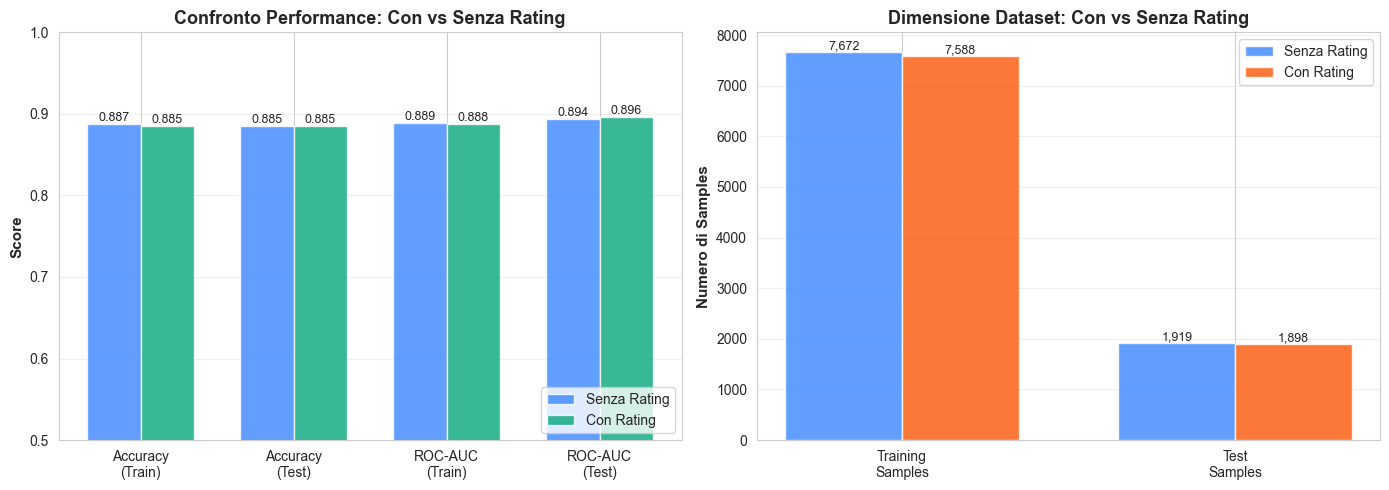

In [39]:
# Visualizzazione Comparativa delle Performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Confronto Accuracy e ROC-AUC
metrics_comparison = pd.DataFrame({
    'Metrica': ['Accuracy\n(Train)', 'Accuracy\n(Test)', 'ROC-AUC\n(Train)', 'ROC-AUC\n(Test)'],
    'Senza Rating': [acc_train_v1, acc_test_v1, auc_train_v1, auc_test_v1],
    'Con Rating': [acc_train_v2, acc_test_v2, auc_train_v2, auc_test_v2]
})

x = np.arange(len(metrics_comparison['Metrica']))
width = 0.35

bars1 = axes[0].bar(x - width/2, metrics_comparison['Senza Rating'], width, 
                     label='Senza Rating', color='#3A86FF', alpha=0.8)
bars2 = axes[0].bar(x + width/2, metrics_comparison['Con Rating'], width, 
                     label='Con Rating', color='#06A77D', alpha=0.8)

axes[0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0].set_title('Confronto Performance: Con vs Senza Rating', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_comparison['Metrica'], fontsize=10)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].set_ylim([0.5, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')

# Aggiungi valori sulle barre
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)

# Grafico 2: Confronto Dataset Size
size_comparison = pd.DataFrame({
    'Set': ['Training\nSamples', 'Test\nSamples'],
    'Senza Rating': [X_train_v1.shape[0], X_test_v1.shape[0]],
    'Con Rating': [X_train_v2.shape[0], X_test_v2.shape[0]]
})

x2 = np.arange(len(size_comparison['Set']))
bars3 = axes[1].bar(x2 - width/2, size_comparison['Senza Rating'], width, 
                     label='Senza Rating', color='#3A86FF', alpha=0.8)
bars4 = axes[1].bar(x2 + width/2, size_comparison['Con Rating'], width, 
                     label='Con Rating', color='#FB5607', alpha=0.8)

axes[1].set_ylabel('Numero di Samples', fontsize=11, fontweight='bold')
axes[1].set_title('Dimensione Dataset: Con vs Senza Rating', fontsize=13, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(size_comparison['Set'], fontsize=10)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Aggiungi valori sulle barre
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


📊 CLASSIFICATION REPORT - Modello CON Rating (Test Set):
              precision    recall  f1-score   support

     Non-Hit       0.89      0.99      0.94      1621
         Hit       0.77      0.30      0.43       277

    accuracy                           0.88      1898
   macro avg       0.83      0.64      0.68      1898
weighted avg       0.87      0.88      0.86      1898



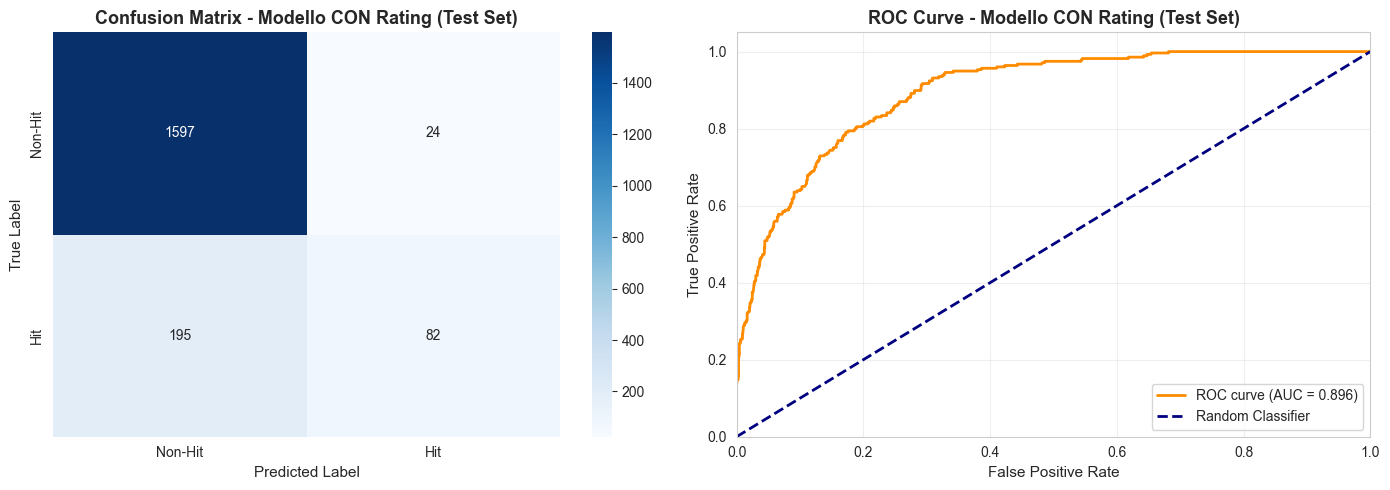

In [40]:
# Classification Report dettagliato per MODELLO CON RATING (V2)
print("\n📊 CLASSIFICATION REPORT - Modello CON Rating (Test Set):")
print("=" * 80)
print(classification_report(y_test_v2, y_pred_test_v2, target_names=['Non-Hit', 'Hit']))

# Confusion Matrix
cm_v2 = confusion_matrix(y_test_v2, y_pred_test_v2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Non-Hit', 'Hit'], yticklabels=['Non-Hit', 'Hit'])
axes[0].set_title('Confusion Matrix - Modello CON Rating (Test Set)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# ROC Curve
fpr_v2, tpr_v2, thresholds_v2 = roc_curve(y_test_v2, y_pred_proba_test_v2)
roc_auc_v2 = roc_auc_score(y_test_v2, y_pred_proba_test_v2)

axes[1].plot(fpr_v2, tpr_v2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_v2:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve - Modello CON Rating (Test Set)', fontsize=13, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🔍 ANALISI COEFFICIENTI DEL MODELLO

Coefficienti delle Feature (ordine di importanza):
            Feature  Coefficient  Abs_Coefficient
  Platform_Hit_Rate     6.432307         6.432307
 Developer_Hit_Rate     6.361209         6.361209
Publisher_Avg_Sales     0.630252         0.630252
              Genre    -0.025892         0.025892
             Rating    -0.023607         0.023607
           Platform     0.017393         0.017393
          Publisher    -0.000408         0.000408
          Developer     0.000080         0.000080

Intercept: -4.3006


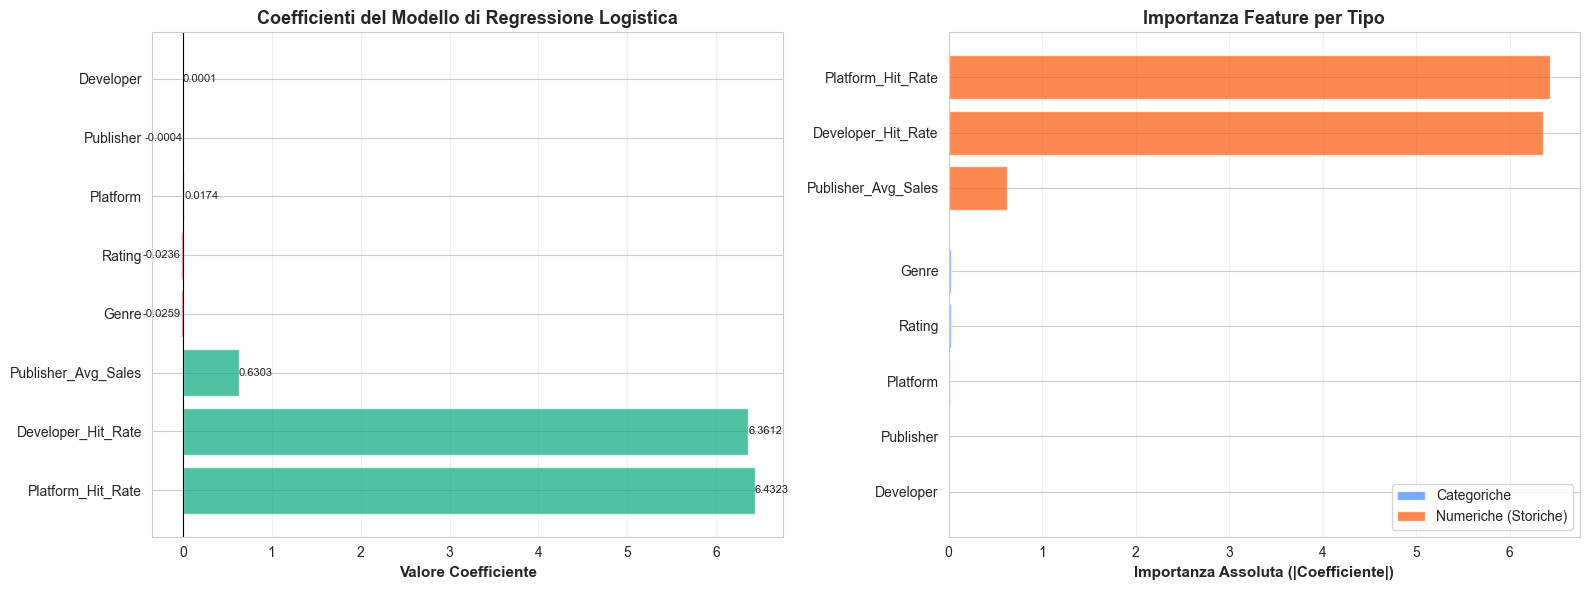


💡 INTERPRETAZIONE:
   - Coefficienti POSITIVI → aumentano la probabilità di essere un Hit
   - Coefficienti NEGATIVI → diminuiscono la probabilità di essere un Hit

📊 FEATURE STORICHE AGGIUNTE:
   - Publisher_Avg_Sales: Media vendite storiche del publisher
   - Developer_Hit_Rate: % di hit storici del developer
   - Platform_Hit_Rate: % di hit storici della piattaforma


In [41]:
# Analisi dei coefficienti del modello
print("\n🔍 ANALISI COEFFICIENTI DEL MODELLO")
print("=" * 80)

# Crea dataframe con i coefficienti
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': np.abs(model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nCoefficienti delle Feature (ordine di importanza):")
print(coef_df.to_string(index=False))

print(f"\nIntercept: {model.intercept_[0]:.4f}")

# Separa feature categoriche e numeriche per la visualizzazione
coef_df['Type'] = coef_df['Feature'].apply(lambda x: 'Numerica (Storica)' if x in numerical_features else 'Categorica')

# Visualizzazione dei coefficienti
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Grafico 1: Tutti i coefficienti
colors = ['#E63946' if x < 0 else '#06A77D' for x in coef_df['Coefficient']]
ax1.barh(range(len(coef_df)), coef_df['Coefficient'], color=colors, alpha=0.7)

ax1.set_yticks(range(len(coef_df)))
ax1.set_yticklabels(coef_df['Feature'])
ax1.set_xlabel('Valore Coefficiente', fontsize=11, fontweight='bold')
ax1.set_title('Coefficienti del Modello di Regressione Logistica', fontsize=13, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='x')

# Aggiungi valori sui bar
for i, (idx, row) in enumerate(coef_df.iterrows()):
    value = row['Coefficient']
    x_pos = value + (0.0005 if value > 0 else -0.0005)
    ha = 'left' if value > 0 else 'right'
    ax1.text(x_pos, i, f"{value:.4f}", va='center', ha=ha, fontsize=8)

# Grafico 2: Importanza assoluta per tipo
coef_categorical = coef_df[coef_df['Type'] == 'Categorica'].sort_values('Abs_Coefficient', ascending=True)
coef_numerical = coef_df[coef_df['Type'] == 'Numerica (Storica)'].sort_values('Abs_Coefficient', ascending=True)

y_pos = 0
y_labels = []
y_ticks = []
bar_colors = []

# Aggiungi feature categoriche
for idx, row in coef_categorical.iterrows():
    ax2.barh(y_pos, row['Abs_Coefficient'], color='#3A86FF', alpha=0.7)
    y_labels.append(row['Feature'])
    y_ticks.append(y_pos)
    bar_colors.append('#3A86FF')
    y_pos += 1

# Spazio tra i gruppi
y_pos += 0.5

# Aggiungi feature numeriche
for idx, row in coef_numerical.iterrows():
    ax2.barh(y_pos, row['Abs_Coefficient'], color='#FB5607', alpha=0.7)
    y_labels.append(row['Feature'])
    y_ticks.append(y_pos)
    bar_colors.append('#FB5607')
    y_pos += 1

ax2.set_yticks(y_ticks)
ax2.set_yticklabels(y_labels)
ax2.set_xlabel('Importanza Assoluta (|Coefficiente|)', fontsize=11, fontweight='bold')
ax2.set_title('Importanza Feature per Tipo', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Aggiungi legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3A86FF', alpha=0.7, label='Categoriche'),
    Patch(facecolor='#FB5607', alpha=0.7, label='Numeriche (Storiche)')
]
ax2.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETAZIONE:")
print("   - Coefficienti POSITIVI → aumentano la probabilità di essere un Hit")
print("   - Coefficienti NEGATIVI → diminuiscono la probabilità di essere un Hit")
print("\n📊 FEATURE STORICHE AGGIUNTE:")
print("   - Publisher_Avg_Sales: Media vendite storiche del publisher")
print("   - Developer_Hit_Rate: % di hit storici del developer")
print("   - Platform_Hit_Rate: % di hit storici della piattaforma")
print("=" * 80)

In [42]:
# Esempio di predizione per nuovi giochi
print("\n🎮 ESEMPIO: Predizione per Nuovi Giochi")
print("=" * 80)

# Esempio 1: Un gioco con caratteristiche tipiche di un hit
esempio_hit = pd.DataFrame({
    'Platform': ['PS2'],
    'Genre': ['Action'],
    'Publisher': ['Electronic Arts'],
    'Developer': ['EA Sports']
})

# Esempio 2: Un gioco con caratteristiche meno favorevoli
esempio_non_hit = pd.DataFrame({
    'Platform': ['PC'],
    'Genre': ['Puzzle'],
    'Publisher': ['Unknown Publisher'],
    'Developer': ['Small Studio']
})

def predict_game(game_df, name="Gioco"):
    """Predice se un gioco sarà un hit"""
    try:
        # Codifica le feature
        game_encoded = game_df.copy()
        for col in features:
            if col in label_encoders:
                # Gestisci categorie non viste nel training
                try:
                    game_encoded[col] = label_encoders[col].transform(game_df[col].astype(str))
                except ValueError:
                    # Se la categoria non è stata vista, usa la categoria più frequente
                    game_encoded[col] = 0
                    print(f"   ⚠️ Categoria '{game_df[col].values[0]}' non vista per {col}, uso valore di default")
        
        # Predizione
        prob = model.predict_proba(game_encoded[features])[0]
        pred = model.predict(game_encoded[features])[0]
        
        print(f"\n{name}:")
        for col in features:
            print(f"   {col}: {game_df[col].values[0]}")
        print(f"\n   Predizione: {'🔥 HIT' if pred == 1 else '❄️ NON-HIT'}")
        print(f"   Probabilità Hit: {prob[1]:.2%}")
        print(f"   Probabilità Non-Hit: {prob[0]:.2%}")
        
    except Exception as e:
        print(f"\n{name}: Errore nella predizione - {e}")

predict_game(esempio_hit, "Esempio 1 (Gioco PS2 Action)")
predict_game(esempio_non_hit, "Esempio 2 (Gioco PC Puzzle)")

print("\n" + "=" * 80)


🎮 ESEMPIO: Predizione per Nuovi Giochi

Esempio 1 (Gioco PS2 Action): Errore nella predizione - name 'features' is not defined

Esempio 2 (Gioco PC Puzzle): Errore nella predizione - name 'features' is not defined

